# Message passing - control paths

In [1]:
import Pkg;
Pkg.activate("."); 
Pkg.instantiate();

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/infer-controlpaths/mp-controlpaths`


In [2]:
using Revise
using RxInfer
using Optim
using Plots
default(label="")

includet("Robots.jl"); using. Robots
includet("util.jl")

In [3]:
# Time
Δt = 0.2
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)

# Dimensions
Dy = 2
Dx = 4
Du = 2

# State transition
A = [1. 0. Δt 0.;
     0. 1. 0. Δt;
     0. 0. 1. 0.;
     0. 0. 0. 1.]

# Control matrix
B = [0. 0.;
     0. 0.;
     Δt 0.;
     0. Δt]

# Process noise covariance matrix
σ = [1e-4; 1e-4]
Q = [Δt^3/3*σ[1]            0.0    Δt^2/2*σ[1]            0.0;
     0.0            Δt^3/3*σ[2]            0.0    Δt^2/2*σ[2];
     Δt^2/2*σ[1]            0.0         Δt*σ[1]           0.0;
     0.0            Δt^2/2*σ[2]            0.0        Δt*σ[2]]

# Measurement function     
C = [1. 0. 0. 0.;
     0. 1. 0. 0.]

# Measurement noise covariance matrix
ρ = [1e-6, 1e-6]
R = diagm(ρ)

# Control prior covariance matrix
E = 1e-2diagm(ones(Du))

# State prior parameters
m_0 = [0.0, 0.0, 0., 0.]
S_0 = 1e6diagm(ones(Dx));

# Goal prior
x_star = [-1.0, 1.0, 0.0, 0.0]
m_star = C*x_star
S_star = 1e-4*diagm(ones(Dy))

2×2 Matrix{Float64}:
 0.0001  0.0
 0.0     0.0001

In [4]:
@model function dynamic_control_priors(y_k, u_k, A,B,C,E,Q,R,T, m_kmin1, S_kmin1, m_star, S_star)
    
    # Transition function 
    x_k ~ MvNormalMeanCovariance(A*m_kmin1 + B*u_k, Q + A*S_kmin1*A')
    
    # Measurement function
    y_k ~ MvNormalMeanCovariance(C*x_k, R)

    u_0 ~ MvNormalMeanCovariance(zeros(Du), E)

    u_tmin1 = u_0
    x_tmin1 = x_k
    for t in 1:T

        # Control prior
        u_[t] ~ MvNormalMeanCovariance(u_tmin1, E)
        
        # Transition function 
        x_[t] ~ MvNormalMeanCovariance(A*x_tmin1 + B*u_[t], Q)
        
        # Measurement function
        y_[t] ~ MvNormalMeanCovariance(C*x_[t], R)

        # Future observation prior
        y_[t] ~ MvNormalMeanCovariance(m_star, S_star)

        x_tmin1 = x_[t]
        u_tmin1 = u_[t]
        
    end
end

In [13]:
len_horizon = 50

# Initial state
x_0 = [0.0, 0.0, 0., 0.]

# Initialize robot
control_lims = (-1., 1.)
bot = FieldBot(ρ,σ, Δt=Δt, control_lims=control_lims)

y_sim = zeros(Dy, len_trial)
x_sim = zeros(Dx, len_trial)
u_sim = zeros(Du, len_trial+1)

x_kmin1 = x_0
m_kmin1 = x_0
S_kmin1 = 1e4*diagm(ones(Dx))

init = @initialization begin
    μ(u_0) = MvNormalMeanCovariance(zeros(Du), diagm(ones(Du)))
    q(u_0) = MvNormalMeanCovariance(zeros(Du), diagm(ones(Du)))
    μ(u_) = MvNormalMeanCovariance(zeros(Du), diagm(ones(Du)))
    q(u_) = MvNormalMeanCovariance(zeros(Du), diagm(ones(Du)))
end

results = []

for k in 1:len_trial

    # Evolve system
    y_sim[:,k], x_sim[:,k] = update(bot, x_kmin1, u_sim[:,k])
    x_kmin1 = x_sim[:,k]

    # Agent absorbs observation
    res = infer(
        model = dynamic_control_priors(A=A,B=B,C=C,E=E,Q=Q,R=R,T=len_horizon),
        data = (y_k = y_sim[:,k], 
                u_k = u_sim[:,k],
                m_kmin1 = m_kmin1,
                S_kmin1 = S_kmin1,
                m_star = m_star,
                S_star = S_star),
        initialization = init,
    )
    push!(results, res)

    # Extract state posterior
    m_kmin1 = mean(res.posteriors[:x_k])
    S_kmin1 = cov(res.posteriors[:x_k])

    # Extract control posterior
    u_sim[:,k+1] = mean(res.posteriors[:u_][1])

end


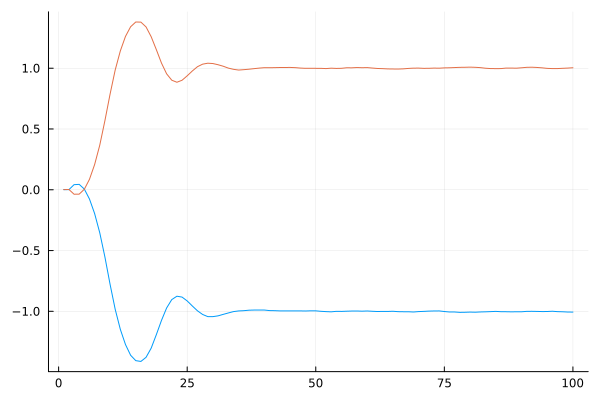

In [14]:
plot(y_sim')

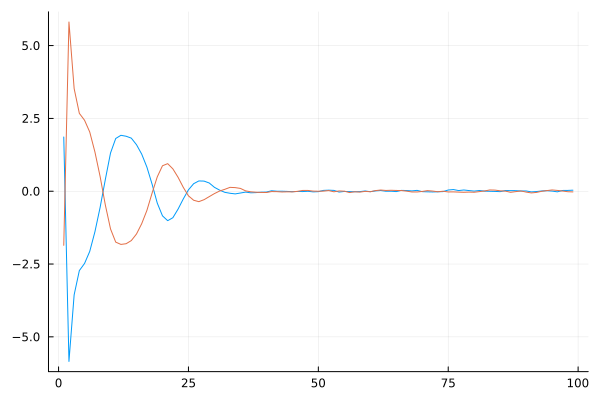

In [15]:
plot(u_sim[:,2:end-1]')

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/infer-controlpaths/mp-controlpaths/figures/trial-dynamicpriors.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/infer-controlpaths/mp-controlpaths/figures/trial-dynamicpriors.gif")
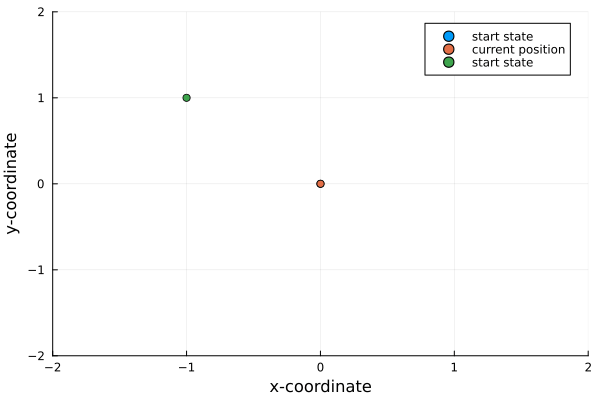

In [16]:
anim = @animate for k in 1:len_trial

    plot(xlabel="x-coordinate", 
         ylabel="y-coordinate",
         xlims=(-2., 2.),
         ylims=(-2., 2.))

    scatter!([x_0[1]], [x_0[2]], label="start state")
    scatter!([x_sim[1,k]], [x_sim[2,k]], label="current position")
    scatter!([x_star[1]], [x_star[2]], label="start state")
    
end
gif(anim, "figures/trial-dynamicpriors.gif", fps=2)